In [1]:
import torch
import os
import sys
if "/opt/ml/level2_cv_semanticsegmentation-cv-09" not in sys.path:
    sys.path.append(os.path.join("/opt/ml/level2_cv_semanticsegmentation-cv-09"))
    
from dataset.dataset import split_dataset
from torch.utils.data import Dataset, DataLoader
from utils import *
from dataset.transforms import get_train_transform
import json
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
seed_everything(42)

train_filenames, train_labelnames, val_filenames, val_labelnames = split_dataset()

In [3]:
class XRayDataset(Dataset):
    
    CLASSES = [
        'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
        'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
        'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
        'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
        'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
        'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
        ]
    
    PALETE = [
            (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
            (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
            (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
            (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
            (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
            (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
        ]
    
    CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
    IND2CLASS = {v: k for k, v in CLASS2IND.items()}
    
    def __init__(self,
                 filenames,
                 labelnames,
                 data_dir="/opt/ml/train/DCM",
                 label_dir="/opt/ml/train/outputs_json",
                 is_train=True,
                 transforms=None):
        
        self.image_root = data_dir
        self.label_dir = label_dir
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(self.image_root, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(self.label_dir, label_name)
        
        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(self.CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = self.CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label
    
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = XRayDataset.PALETE[i]
        
    return image

In [4]:
train_transform = get_train_transform(img_size=(512,512))

train_dataset = XRayDataset(
                            filenames = train_filenames,
                            labelnames = train_labelnames,
                            transforms= train_transform
                            )


In [5]:
img, mask = train_dataset.__getitem__(0)
print(img.shape, mask.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


(512, 512, 3)


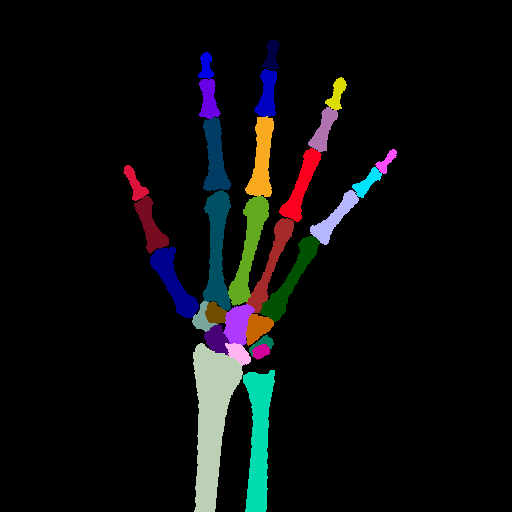

In [6]:
gt_img = label2rgb(mask)
print(gt_img.shape)
Image.fromarray(gt_img)

## cutout

In [7]:
img1, mask1 = train_dataset.__getitem__(1)
img2, mask2 = train_dataset.__getitem__(2)
mask1 = label2rgb(mask1)
mask2 = label2rgb(mask2)
alpha = 0.5
mixup_img = (alpha*img1*255 + (1-alpha)*img2*255)
mixup_mask = np.uint8((alpha*mask1 + (1-alpha)*mask2))
print(mixup_img.shape, mixup_mask.shape)

torch.Size([3, 512, 512]) (512, 512, 3)


(512, 512, 3)
(512, 1024, 3)


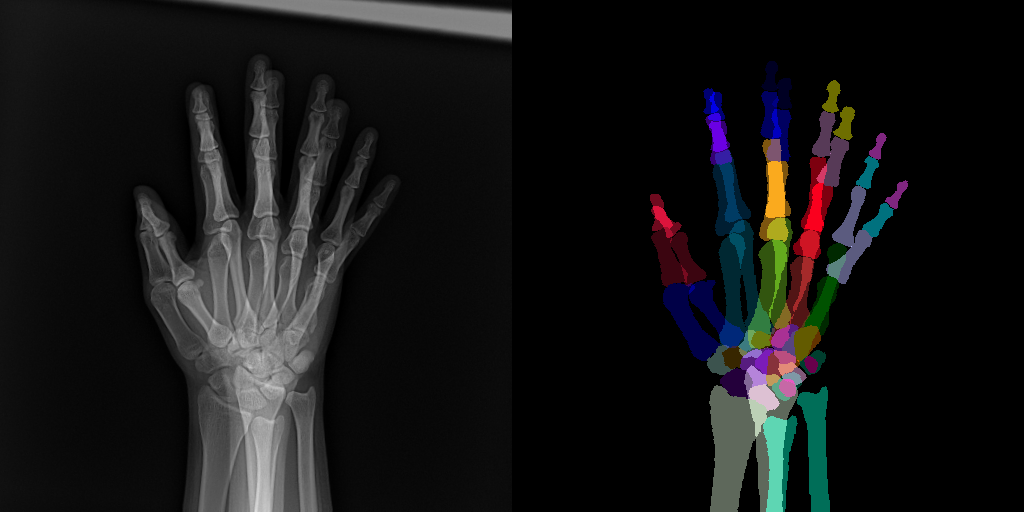

In [8]:

img_plot = np.uint8(mixup_img.permute(1,2,0))
print(img_plot.shape)
p = np.concatenate((img_plot,mixup_mask),axis=1)
print(p.shape)
Image.fromarray(p)

## Mixup collate fn

In [19]:
def cutmix_collate_fn(batch):
    def rand_bbox(size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int16(W * cut_rat)
        cut_h = np.int16(H * cut_rat)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        return bbx1, bby1, bbx2, bby2

    p = random.random()
    img, label = zip(*batch)
    img = torch.stack(img,0)
    label = torch.stack(label,0)
    if p > 0.5:    
        indice = torch.randperm(len(batch))
        alpha = np.random.beta(1,1)
        
        shuffle_img = img[indice]
        shuffle_label = label[indice]
        
        bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(),alpha)
        img[:,:,bby1:bby2,bbx1:bbx2] = shuffle_img[:,:,bby1:bby2,bbx1:bbx2]
        label[:,:,bby1:bby2,bbx1:bbx2] = shuffle_label[:,:,bby1:bby2,bbx1:bbx2]

        return img,label
    else:
        return img,label
        

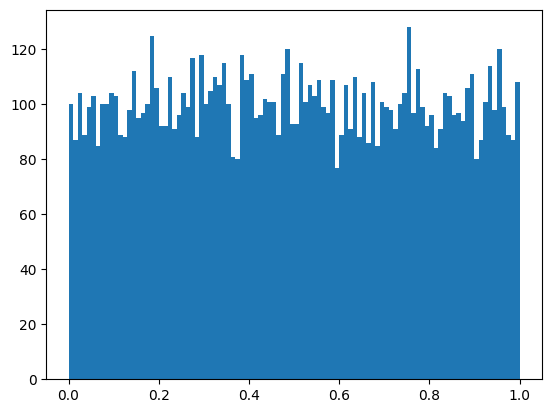

In [20]:
result = []
for i in range(10000):
    beta = np.random.beta(1,1)
    result.append(beta)
result.sort()
plt.hist(result,bins=100)
plt.show()

In [21]:
train_loader = DataLoader(
        dataset=train_dataset, 
        batch_size=4,
        shuffle=True,
        num_workers=0,
        drop_last=True,
        collate_fn=cutmix_collate_fn
    )

for img, label in iter(train_loader):
    print(img.shape, label.shape)
    break

torch.Size([4, 3, 512, 512]) torch.Size([4, 29, 512, 512])


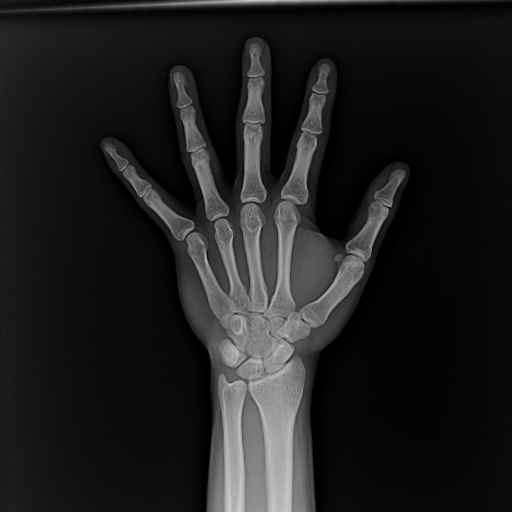

In [22]:
img_plot = np.uint8(img[0].permute(1,2,0)*255)
Image.fromarray(img_plot)